In [82]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from collections import namedtuple
import datetime

## Data Exploration

In [83]:
df = pd.read_csv('../data/filtered_train.csv')
pd.set_option('display.max_columns',None)
df.head()

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,128037,1.107451e+19,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157
1,491755,1.240012e+19,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9f351a94,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79
2,470924,1.059801e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,158aae2e,c144e605,1,0,17614,320,50,1993,2,1063,-1,33
3,791624,1.844219e+18,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,87f758ac,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23
4,491263,1.236016e+19,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d55aa41c,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33


In [84]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                404290 non-null  float64
 1   click             404290 non-null  int64  
 2   hour              404290 non-null  int64  
 3   C1                404290 non-null  int64  
 4   banner_pos        404290 non-null  int64  
 5   site_id           404290 non-null  object 
 6   site_domain       404290 non-null  object 
 7   site_category     404290 non-null  object 
 8   app_id            404290 non-null  object 
 9   app_domain        404290 non-null  object 
 10  app_category      404290 non-null  object 
 11  device_id         404290 non-null  object 
 12  device_ip         404290 non-null  object 
 13  device_model      404290 non-null  object 
 14  device_type       404290 non-null  int64  
 15  device_conn_type  404290 non-null  int64  
 16  C14               40

In [86]:
df['click'].value_counts()

click
0    335635
1     68655
Name: count, dtype: int64

In [87]:
df.nunique()

id                  402586
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               2225
site_domain           2188
site_category           22
app_id                2241
app_domain             143
app_category            27
device_id            64742
device_ip           261706
device_model          4380
device_type              4
device_conn_type         4
C14                   2088
C15                      8
C16                      9
C17                    411
C18                      4
C19                     65
C20                    161
C21                     60
dtype: int64

Based on explorative data analysis, hour of the day is be importance

In [88]:
df['hour_of_day'] = df['hour'].astype(str).str.slice(6, 8).astype(int) #hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
df = df.drop('id', axis = 1)
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157,1
1,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9f351a94,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79,3
2,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,158aae2e,c144e605,1,0,17614,320,50,1993,2,1063,-1,33,3
3,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,87f758ac,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23,4
4,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d55aa41c,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33,3


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   click             404290 non-null  int64 
 1   hour              404290 non-null  int64 
 2   C1                404290 non-null  int64 
 3   banner_pos        404290 non-null  int64 
 4   site_id           404290 non-null  object
 5   site_domain       404290 non-null  object
 6   site_category     404290 non-null  object
 7   app_id            404290 non-null  object
 8   app_domain        404290 non-null  object
 9   app_category      404290 non-null  object
 10  device_id         404290 non-null  object
 11  device_ip         404290 non-null  object
 12  device_model      404290 non-null  object
 13  device_type       404290 non-null  int64 
 14  device_conn_type  404290 non-null  int64 
 15  C14               404290 non-null  int64 
 16  C15               404290 non-null  int

## Feature Encoding

In [90]:
df.nunique().sort_values(ascending=False)

device_ip           261706
device_id            64742
device_model          4380
app_id                2241
site_id               2225
site_domain           2188
C14                   2088
C17                    411
hour                   240
C20                    161
app_domain             143
C19                     65
C21                     60
app_category            27
hour_of_day             24
site_category           22
C16                      9
C15                      8
banner_pos               7
C1                       7
device_conn_type         4
device_type              4
C18                      4
click                    2
dtype: int64

In [91]:
df = df.drop(columns=(['device_ip','device_id']))

In [92]:
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157,1
1,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79,3
2,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,c144e605,1,0,17614,320,50,1993,2,1063,-1,33,3
3,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23,4
4,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33,3


In [93]:
obj_features = list(df.select_dtypes(['object']).columns)
int_features = list(df.select_dtypes(['int64']).columns)
int_features.remove('click')

df[obj_features] = df[obj_features].fillna('-1', )
df[int_features] = df[int_features].fillna(0, )

for feat in obj_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [94]:
dense_features = df.loc[:, df.nunique() <= 100].columns.tolist()
dense_features.remove('click')

In [95]:
dense_features

['C1',
 'banner_pos',
 'site_category',
 'app_category',
 'device_type',
 'device_conn_type',
 'C15',
 'C16',
 'C18',
 'C19',
 'C21',
 'hour_of_day']

In [96]:
for feat in dense_features:
  df_temp = pd.get_dummies(df[feat], prefix=[feat], dtype=float)
  df = df.drop(feat, axis=1)
  df = pd.concat([df, df_temp], axis=1)
df.head()

,click,hour,site_id,site_domain,app_id,app_domain,device_model,C14,C17,C20,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_3,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['site_category']_19,['site_category']_20,['site_category']_21,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['app_category']_22,['app_category']_23,['app_category']_24,['app_category']_25,['app_category']_26,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_120,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_20,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_38,['C19']_39,['C19']_41,['C19']_43,['C19']_45,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_289,['C19']_290,['C19']_291,['C19']_295,['C19']_297,['C19']_299,['C19']_303,['C19']_417,['C19']_419,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_555,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_803,['C19']_809,['C19']_811,['C19']_813,['C19']_815,['C19']_935,['C19']_937,['C19']_939,['C19']_943,['C19']_1059,['C19']_1063,['C19']_1065,['C19']_1071,['C19']_1195,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1575,['C19']_1583,['C19']_1711,['C19']_1831,['C19']_1835,['C19']_1839,['C21']_1,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_76,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,['C21']_100,['C21']_101,['C21']_102,['C21']_104,['C21']_108,['C21']_110,['C21']_111,['C21']_112,['C21']_116,['C21']_117,['C21']_126,['C21']_156,['C21']_157,['C21']_159,['C21']_163,['C21']_171,['C21']_177,['C21']_178,['C21']_182,['C21']_194,['C21']_195,['C21']_204,['C21']_212,['C21']_219,['C21']_221,['C21']_229,['C21']_246,['C21']_251,['C21']_253,['C21']_255,['hour_of_day']_0,['hour_of_day']_1,['hour_of_day']_2,['hour_of_day']_3,['hour_of_day']_4,['hour_of_day']_5,['hour_of_day']_6,['hour_of_day']_7,['hour_of_day']_8,['hour_of_day']_9,['hour_of_day']_10,['hour_of_day']_11,['hour_of_day']_12,['hour_of_day']_13,['hour_of_day']_14,['hour_of_day']_15,['hour_of_day']_16,['hour_of_day']_17,['hour_of_day']_18,['hour_of_day']_19,['hour_of_day']_20,['hour_of_day']_21,['hour_of_day']_22,['hour_of_day']_23
0,0,14102101,1939,1096,2060,63,2331,20352,2333,-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [97]:
sparse_features = [feat for feat, feat_num in df.nunique().items() if feat_num > 100]
sparse_features

['hour',
 'site_id',
 'site_domain',
 'app_id',
 'app_domain',
 'device_model',
 'C14',
 'C17',
 'C20']

In [98]:
df.shape

(404290, 251)

In [99]:
embedding_dict = [{'feat': feat, 'feat_num': df[feat].nunique(), 'embed_dim': 128} for feat in sparse_features]
embedding_dict

[{'feat': 'hour', 'feat_num': 240, 'embed_dim': 128},
 {'feat': 'site_id', 'feat_num': 2225, 'embed_dim': 128},
 {'feat': 'site_domain', 'feat_num': 2188, 'embed_dim': 128},
 {'feat': 'app_id', 'feat_num': 2241, 'embed_dim': 128},
 {'feat': 'app_domain', 'feat_num': 143, 'embed_dim': 128},
 {'feat': 'device_model', 'feat_num': 4380, 'embed_dim': 128},
 {'feat': 'C14', 'feat_num': 2088, 'embed_dim': 128},
 {'feat': 'C17', 'feat_num': 411, 'embed_dim': 128},
 {'feat': 'C20', 'feat_num': 161, 'embed_dim': 128}]

In [100]:
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [101]:
df.head()

,click,hour,site_id,site_domain,app_id,app_domain,device_model,C14,C17,C20,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_3,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['site_category']_19,['site_category']_20,['site_category']_21,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['app_category']_22,['app_category']_23,['app_category']_24,['app_category']_25,['app_category']_26,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_120,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_20,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_38,['C19']_39,['C19']_41,['C19']_43,['C19']_45,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_289,['C19']_290,['C19']_291,['C19']_295,['C19']_297,['C19']_299,['C19']_303,['C19']_417,['C19']_419,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_555,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_803,['C19']_809,['C19']_811,['C19']_813,['C19']_815,['C19']_935,['C19']_937,['C19']_939,['C19']_943,['C19']_1059,['C19']_1063,['C19']_1065,['C19']_1071,['C19']_1195,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1575,['C19']_1583,['C19']_1711,['C19']_1831,['C19']_1835,['C19']_1839,['C21']_1,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_76,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,['C21']_100,['C21']_101,['C21']_102,['C21']_104,['C21']_108,['C21']_110,['C21']_111,['C21']_112,['C21']_116,['C21']_117,['C21']_126,['C21']_156,['C21']_157,['C21']_159,['C21']_163,['C21']_171,['C21']_177,['C21']_178,['C21']_182,['C21']_194,['C21']_195,['C21']_204,['C21']_212,['C21']_219,['C21']_221,['C21']_229,['C21']_246,['C21']_251,['C21']_253,['C21']_255,['hour_of_day']_0,['hour_of_day']_1,['hour_of_day']_2,['hour_of_day']_3,['hour_of_day']_4,['hour_of_day']_5,['hour_of_day']_6,['hour_of_day']_7,['hour_of_day']_8,['hour_of_day']_9,['hour_of_day']_10,['hour_of_day']_11,['hour_of_day']_12,['hour_of_day']_13,['hour_of_day']_14,['hour_of_day']_15,['hour_of_day']_16,['hour_of_day']_17,['hour_of_day']_18,['hour_of_day']_19,['hour_of_day']_20,['hour_of_day']_21,['hour_of_day']_22,['hour_of_day']_23
0,0,1,1939,1096,2060,63,2331,564,144,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0

In [102]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [103]:
device = torch.device("mps")

In [104]:
device

device(type='mps')

In [105]:
df.shape

(404290, 251)

In [106]:
df.head()

,click,hour,site_id,site_domain,app_id,app_domain,device_model,C14,C17,C20,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_3,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['site_category']_19,['site_category']_20,['site_category']_21,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['app_category']_22,['app_category']_23,['app_category']_24,['app_category']_25,['app_category']_26,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_120,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_20,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_38,['C19']_39,['C19']_41,['C19']_43,['C19']_45,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_289,['C19']_290,['C19']_291,['C19']_295,['C19']_297,['C19']_299,['C19']_303,['C19']_417,['C19']_419,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_555,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_803,['C19']_809,['C19']_811,['C19']_813,['C19']_815,['C19']_935,['C19']_937,['C19']_939,['C19']_943,['C19']_1059,['C19']_1063,['C19']_1065,['C19']_1071,['C19']_1195,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1575,['C19']_1583,['C19']_1711,['C19']_1831,['C19']_1835,['C19']_1839,['C21']_1,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_76,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,['C21']_100,['C21']_101,['C21']_102,['C21']_104,['C21']_108,['C21']_110,['C21']_111,['C21']_112,['C21']_116,['C21']_117,['C21']_126,['C21']_156,['C21']_157,['C21']_159,['C21']_163,['C21']_171,['C21']_177,['C21']_178,['C21']_182,['C21']_194,['C21']_195,['C21']_204,['C21']_212,['C21']_219,['C21']_221,['C21']_229,['C21']_246,['C21']_251,['C21']_253,['C21']_255,['hour_of_day']_0,['hour_of_day']_1,['hour_of_day']_2,['hour_of_day']_3,['hour_of_day']_4,['hour_of_day']_5,['hour_of_day']_6,['hour_of_day']_7,['hour_of_day']_8,['hour_of_day']_9,['hour_of_day']_10,['hour_of_day']_11,['hour_of_day']_12,['hour_of_day']_13,['hour_of_day']_14,['hour_of_day']_15,['hour_of_day']_16,['hour_of_day']_17,['hour_of_day']_18,['hour_of_day']_19,['hour_of_day']_20,['hour_of_day']_21,['hour_of_day']_22,['hour_of_day']_23
0,0,1,1939,1096,2060,63,2331,564,144,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0

## Pipeline the data

In [140]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train_deep, X_test_deep = train.iloc[:, 1:10], test.iloc[:, 1:10]
X_train_wide, X_test_wide = train.iloc[:, 10:], test.iloc[:, 10:]
Y_train, Y_test = train['click'], test['click']

In [141]:
# Building the output dictionary
wd_dataset = dict()
train_dataset = namedtuple('train_dataset', 'wide, deep, label')
test_dataset  = namedtuple('test_dataset' , 'wide, deep, label')
wd_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, Y_train)
wd_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, Y_test)
wd_dataset['embedding_dict'] = embedding_dict

In [142]:
wd_dataset['train_dataset']

train_dataset(wide=        ['C1']_1001  ['C1']_1002  ['C1']_1005  ['C1']_1007  ['C1']_1008  \
352886          0.0          0.0          1.0          0.0          0.0   
134949          0.0          0.0          1.0          0.0          0.0   
168419          0.0          0.0          1.0          0.0          0.0   
402543          0.0          0.0          1.0          0.0          0.0   
13551           0.0          0.0          1.0          0.0          0.0   
...             ...          ...          ...          ...          ...   
259178          0.0          0.0          1.0          0.0          0.0   
365838          0.0          0.0          1.0          0.0          0.0   
131932          0.0          0.0          1.0          0.0          0.0   
146867          0.0          0.0          1.0          0.0          0.0   
121958          0.0          0.0          1.0          0.0          0.0   

        ['C1']_1010  ['C1']_1012  ['banner_pos']_0  ['banner_pos']_1  \
352886  

In [143]:
class WideDeepDataset(Dataset):
    """Helper to facilitate loading the data to the pytorch models.

    Parameters:
    --------
    data: namedtuple with 3 elements - (wide_input_data, deep_inp_data, target)
    """
    def __init__(self, data):

        self.X_wide = torch.tensor(data.wide.values.astype(np.float32))
        self.X_deep =  torch.tensor(data.deep.values.astype(np.float32))
        self.Y =  torch.tensor(data.label.values.astype(np.float32))
        self.Y = self.Y.squeeze().unsqueeze(1)

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)

In [144]:
dl_train_dataset = WideDeepDataset(wd_dataset['train_dataset'])
dl_test_dataset = WideDeepDataset(wd_dataset['test_dataset'])

In [145]:
dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size = 128)
dl_val = DataLoader(dl_test_dataset, shuffle=True, batch_size = 128)

In [146]:
# test for traning dara
for (X_wide, X_deep, label) in iter(dl_train):
    print(X_wide.shape, X_deep.shape, label.shape)
    break

torch.Size([128, 241]) torch.Size([128, 9]) torch.Size([128, 1])


## Model Building

In [153]:
class FM(nn.Module):
    """FM part"""
    def __init__(self, embedding_dim, total_dim):
        """
        embedding_dim: the dimension of each categorical embedding -> makes the dimension of latent vector k equals to dim of embedding
        total_dim: dim of discrete feature + dim of embeddings of whole categorical features
        """
        super(FM, self).__init__()
        
        self.latent_dim = embedding_dim
        # nn.Parameter(): create trainable parameters which can be updated during training
        self.w0 = nn.Parameter(torch.zeros([1,])) # b
        self.w1 = nn.Parameter(torch.rand([total_dim, 1])) # 1-order feature interaction
        self.w2 = nn.Parameter(torch.rand([total_dim, embedding_dim])) # 2-order feature interaction
        
    def forward(self, x):   
        first_order = self.w0 + torch.mm(x, self.w1)      # (samples_num, 1)
        # print(first_order.shape)
        # print(self.w2.shape)
        second_order = 1/2 * torch.sum(
            torch.pow(torch.mm(x, self.w2), 2) - torch.mm(torch.pow(x,2), torch.pow(self.w2, 2)),
            dim = 1,
            keepdim = True
        )         # (samples_num, 1)
        
        return first_order + second_order 

In [154]:
class Dnn(nn.Module):
    
    def __init__(self, hidden_units, dropout_rate=0., use_bn = False):
       
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p = dropout_rate)
        self.use_bn = use_bn
        if use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])
    
    def forward(self, x):
        
        for i, linear in enumerate(self.dnn_network):
            x = linear(x)
            if self.use_bn:
                x = self.bn[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        return x

In [155]:
class DeepFM(nn.Module):
    def __init__(self, wide_dim, embedding_dict, hidden_units, dnn_dropout = 0., use_bn = False):
        super(DeepFM, self).__init__()
        self.wide_dim = wide_dim
        self.deep_dim = 0
        self.hidden_layers = hidden_units

        # For each deep feature, create an embedding layer to convert them to embeddings
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(embedding_dict)
        })
        for feat in embedding_dict:
            self.deep_dim += int(feat['embed_dim'])
        
        # A series of hidden layers that take the embeddings as input
        hidden_units.insert(0, self.deep_dim + self.wide_dim)
        self.dnn_network = Dnn(hidden_units, dropout_rate=dnn_dropout, use_bn = use_bn)
        self.fm = FM(128, self.deep_dim + self.wide_dim)     
        # Final dense layer that combine the wide features and the deep features and generate output
        self.fc = nn.Linear(self.hidden_layers[-1], 1)

    def forward(self, X_w, X_d):
        X_d = X_d.long() # embedding inputs need integer tensors
        embeddings = [self.embed_layers['embed_' + str(i)](X_d[:, i]) for i in range(X_d.shape[1])]
        embeddings_cat = torch.cat(embeddings, dim=-1) # concatenate the embeddings of all deep features
        x = torch.cat([X_w, embeddings_cat], axis=-1)
        # print('x',x.shape)
        
        # Wide
        wide_outputs = self.fm(x)
        # deep
        deep_outputs = self.fc(self.dnn_network(x))
        # final output
        outputs = F.sigmoid(torch.add(wide_outputs, deep_outputs))
        
        return outputs  

In [162]:
hidden_units = [256, 128, 64]
dnn_dropout = 0.6

model = DeepFM(wd_dataset['train_dataset'].wide.shape[1], wd_dataset['embedding_dict'], hidden_units, dnn_dropout, use_bn=True)
model

DeepFM(
  (embed_layers): ModuleDict(
    (embed_0): Embedding(240, 128)
    (embed_1): Embedding(2225, 128)
    (embed_2): Embedding(2188, 128)
    (embed_3): Embedding(2241, 128)
    (embed_4): Embedding(143, 128)
    (embed_5): Embedding(4380, 128)
    (embed_6): Embedding(2088, 128)
    (embed_7): Embedding(411, 128)
    (embed_8): Embedding(161, 128)
  )
  (dnn_network): Dnn(
    (dnn_network): ModuleList(
      (0): Linear(in_features=1393, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.6, inplace=False)
    (bn): ModuleList(
      (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fm): FM()
  (fc): Linear(in_feat

In [163]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model.to(device)
# Throw an error when only one class present in y_true, thus need to do error processing
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)
metric_func = auc
metric_name = 'auc'

In [164]:
dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
n_epoches = 30
print('Start training......')
starttime = datetime.datetime.now()
print('=='* 30)

for epoch in tqdm(range(1, n_epoches + 1)):
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (X_wide, X_deep, label) in enumerate(dl_train, 1):
        X_wide = X_wide.to(device)
        X_deep = X_deep.to(device)
        label = label.to(device)
        y_pred = model(X_wide, X_deep)
        y_pred = y_pred.cpu()
        label = label.cpu()
        loss = loss_fn(y_pred, label)
        try:          
            metric = metric_func(y_pred, label)
        except ValueError:
            pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

        if step % 5000 == 0:
            print(f"Step {step} of Epoch {epoch}:\n\t Average training loss: {loss_sum/step}.\n\t Average auc score: {metric_sum/step}")
            
    
    # evaluate
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    for val_step, (X_wide, X_deep, label) in enumerate(dl_val, 1):
        with torch.no_grad():
            X_wide = X_wide.to(device)
            X_deep = X_deep.to(device)
            label = label.to(device)
            y_pred = model(X_wide, X_deep)
            y_pred = y_pred.cpu()
            label = label.cpu()
            val_loss = loss_fn(y_pred, label)
            try:          
                val_metric = metric_func(y_pred, label)
            except ValueError:
                pass
            
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch - 1] = info
    if epoch % 1 == 0:
        print(f"Epoch {epoch} of {n_epoches}:\n\t  Average testing loss: {val_loss_sum/val_step}.\n\t Average auc score: {val_metric_sum/val_step}")
        endtime = datetime.datetime.now()
        print('Training time is {}'.format(endtime - starttime))
        print('=='* 20)


print('Finished Training!')

Start training......


  3%|▎         | 1/30 [00:44<21:26, 44.37s/it]

Epoch 1 of 30:
	  Average testing loss: 0.8019375134306618.
	 Average auc score: 0.5319964962210983
Training time is 0:00:44.370285


  7%|▋         | 2/30 [01:27<20:17, 43.50s/it]

Epoch 2 of 30:
	  Average testing loss: 0.7789832983590379.
	 Average auc score: 0.4925343644287362
Training time is 0:01:27.255253


 10%|█         | 3/30 [02:09<19:22, 43.04s/it]

Epoch 3 of 30:
	  Average testing loss: 0.7581590300873865.
	 Average auc score: 0.5041923243988232
Training time is 0:02:09.751887


 13%|█▎        | 4/30 [02:52<18:35, 42.89s/it]

Epoch 4 of 30:
	  Average testing loss: 0.7686479295356364.
	 Average auc score: 0.4995056896037614
Training time is 0:02:52.422263


 17%|█▋        | 5/30 [03:36<18:05, 43.42s/it]

Epoch 5 of 30:
	  Average testing loss: 0.7661797276026086.
	 Average auc score: 0.5181066146245515
Training time is 0:03:36.788914


 20%|██        | 6/30 [04:19<17:15, 43.16s/it]

Epoch 6 of 30:
	  Average testing loss: 0.7809007197995729.
	 Average auc score: 0.5378546014121954
Training time is 0:04:19.434726


 23%|██▎       | 7/30 [05:03<16:37, 43.35s/it]

Epoch 7 of 30:
	  Average testing loss: 0.7547622856837285.
	 Average auc score: 0.5263888359155172
Training time is 0:05:03.185191


 27%|██▋       | 8/30 [05:45<15:48, 43.13s/it]

Epoch 8 of 30:
	  Average testing loss: 0.7482445465424393.
	 Average auc score: 0.5279158734064787
Training time is 0:05:45.827212


 30%|███       | 9/30 [06:29<15:06, 43.15s/it]

Epoch 9 of 30:
	  Average testing loss: 0.7462439775655542.
	 Average auc score: 0.532271497044589
Training time is 0:06:29.014953


 33%|███▎      | 10/30 [07:12<14:25, 43.29s/it]

Epoch 10 of 30:
	  Average testing loss: 0.7906271382411824.
	 Average auc score: 0.5317644630396476
Training time is 0:07:12.612883


 37%|███▋      | 11/30 [07:56<13:43, 43.37s/it]

Epoch 11 of 30:
	  Average testing loss: 0.7446969903156727.
	 Average auc score: 0.530823178848333
Training time is 0:07:56.168202


 40%|████      | 12/30 [08:38<12:54, 43.00s/it]

Epoch 12 of 30:
	  Average testing loss: 0.7408059165824817.
	 Average auc score: 0.5279895897518484
Training time is 0:08:38.339192


 43%|████▎     | 13/30 [09:23<12:23, 43.73s/it]

Epoch 13 of 30:
	  Average testing loss: 0.7764955012104179.
	 Average auc score: 0.5450829991340712
Training time is 0:09:23.730517


 47%|████▋     | 14/30 [10:09<11:49, 44.35s/it]

Epoch 14 of 30:
	  Average testing loss: 0.7569641032362286.
	 Average auc score: 0.5240388750683384
Training time is 0:10:09.529413


 50%|█████     | 15/30 [10:56<11:15, 45.04s/it]

Epoch 15 of 30:
	  Average testing loss: 0.7415399220359477.
	 Average auc score: 0.52562160225651
Training time is 0:10:56.163965


 53%|█████▎    | 16/30 [11:39<10:24, 44.59s/it]

Epoch 16 of 30:
	  Average testing loss: 0.7405902419852305.
	 Average auc score: 0.5240896455528727
Training time is 0:11:39.706173


 57%|█████▋    | 17/30 [12:23<09:37, 44.41s/it]

Epoch 17 of 30:
	  Average testing loss: 0.7343460713760762.
	 Average auc score: 0.5271709571171299
Training time is 0:12:23.710886


 60%|██████    | 18/30 [13:07<08:50, 44.18s/it]

Epoch 18 of 30:
	  Average testing loss: 0.7451642195257959.
	 Average auc score: 0.528892307662186
Training time is 0:13:07.351711


 63%|██████▎   | 19/30 [13:52<08:07, 44.34s/it]

Epoch 19 of 30:
	  Average testing loss: 0.7570188501024548.
	 Average auc score: 0.5300673833559165
Training time is 0:13:52.046773


 67%|██████▋   | 20/30 [14:36<07:22, 44.24s/it]

Epoch 20 of 30:
	  Average testing loss: 0.7308964590671696.
	 Average auc score: 0.5320570602793017
Training time is 0:14:36.050016


 70%|███████   | 21/30 [15:20<06:39, 44.41s/it]

Epoch 21 of 30:
	  Average testing loss: 0.7427095673695395.
	 Average auc score: 0.5340533561117575
Training time is 0:15:20.849577


 73%|███████▎  | 22/30 [16:05<05:56, 44.54s/it]

Epoch 22 of 30:
	  Average testing loss: 0.7350619473034823.
	 Average auc score: 0.5324694262433489
Training time is 0:16:05.693303


 77%|███████▋  | 23/30 [16:49<05:10, 44.36s/it]

Epoch 23 of 30:
	  Average testing loss: 0.753021163182168.
	 Average auc score: 0.5325747327504569
Training time is 0:16:49.626901


 80%|████████  | 24/30 [17:34<04:26, 44.37s/it]

Epoch 24 of 30:
	  Average testing loss: 0.7797333673585819.
	 Average auc score: 0.5256759170658102
Training time is 0:17:34.015074


 83%|████████▎ | 25/30 [18:17<03:40, 44.15s/it]

Epoch 25 of 30:
	  Average testing loss: 0.735235458027713.
	 Average auc score: 0.5303317987456408
Training time is 0:18:17.678330


 87%|████████▋ | 26/30 [19:01<02:56, 44.02s/it]

Epoch 26 of 30:
	  Average testing loss: 0.7690045037601567.
	 Average auc score: 0.553108921072102
Training time is 0:19:01.384035


 90%|█████████ | 27/30 [19:45<02:12, 44.09s/it]

Epoch 27 of 30:
	  Average testing loss: 0.7318032168889348.
	 Average auc score: 0.5215499741878594
Training time is 0:19:45.631938


 93%|█████████▎| 28/30 [20:29<01:28, 44.06s/it]

Epoch 28 of 30:
	  Average testing loss: 0.7643539228394062.
	 Average auc score: 0.5252785693495703
Training time is 0:20:29.634835


 97%|█████████▋| 29/30 [21:12<00:43, 43.80s/it]

Epoch 29 of 30:
	  Average testing loss: 0.7240186752397803.
	 Average auc score: 0.5306754238336562
Training time is 0:21:12.819643


100%|██████████| 30/30 [21:56<00:00, 43.89s/it]

Epoch 30 of 30:
	  Average testing loss: 0.7203281975433796.
	 Average auc score: 0.5325456465175539
Training time is 0:21:56.751369
Finished Training!


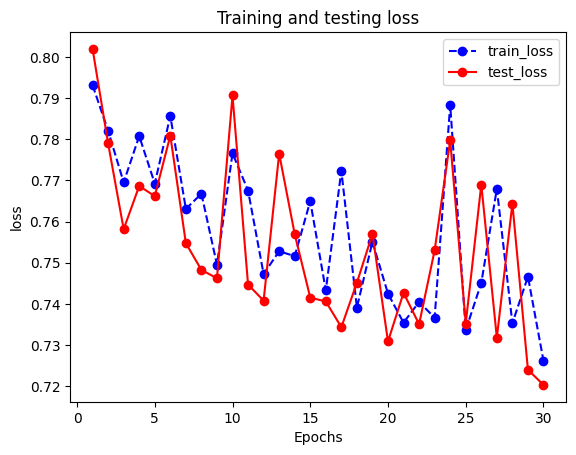

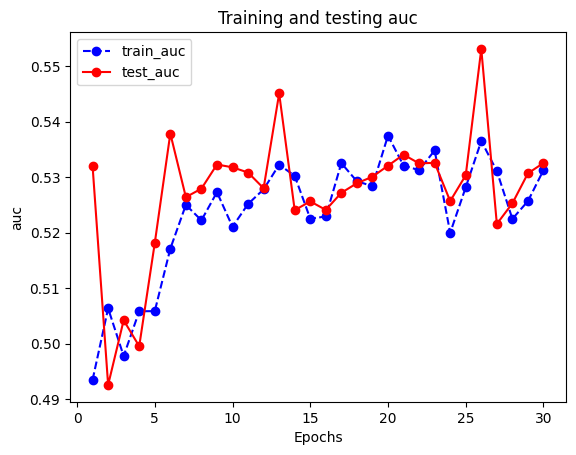

In [166]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and testing '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'test_'+metric])
    plt.show()

plot_metric(dfhistory, "loss")
plot_metric(dfhistory, "auc")